In [1]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import matplotlib.pyplot as plt

In [2]:
class MultiHeadSelfAttention(nn.Module):
    """Multi-Head Self-Attention(マルチヘッド自己注意機構)

    Attributes:
        num_heads: マルチヘッドのヘッド数
        expansion_layer: 特徴マップの各要素のサイズを×3するための全結合層
        headjoin_layer: 各ヘッドから出力された特徴表現を線形変換する全結合層
        scal: ソフトマックス関数入力前に適用するスケール値
        dropout: ドロップアウト率
    """
    def __init__(self,
                 num_inputlayer_units: int,
                 num_heads: int,
                 dropout: float=0.3
                 ):
        super().__init__()
        """マルチヘッドアテンションに必要なレイヤー等の定義

        Args:
            num_inputlayer_units(int): 全結合層(線形層)のユニット数
            num_heads(int) : マルチヘッドアテンションのヘッド数
            dropout(float): ドロップアウト率
        """
        # 特徴マップの特徴量の数をヘッドの数で分割できるか確認
        if num_inputlayer_units % num_heads != 0:
            raise ValueError("num_inputlayer_units must be divisible by num_heads")
        # ヘッドの数を設定
        self.num_heads = num_heads
        # 特徴マップ生成機構の全結合層ユニット数をヘッドの数で割ることで
        # ヘッドごとの特徴量の次元を求める
        dim_head = num_inputlayer_units // num_heads


        # データ拡張を行う全結合層の定義
        # 入力の次元数: 特徴マップの特徴量次元
        # 出力の次元数(ユニット数): 特徴量次元×3
        self.expansion_layer = nn.Linear(
            num_inputlayer_units,     # 入力サイズは特徴マップの特徴量次元と同じ
            num_inputlayer_units * 3, # ユニット数は特徴量次元×3
            bias=False) # バイアスは使わない
        # ソフトマックス関数のオーバーフロー対策のためのスケール値
        # 次元数の平方根の逆数（1/sqrt(dimension)）
        self.scale = 1 / (dim_head ** 0.5)

        # 各ヘッドからの出力を線形変換後に結合する全結合層の定義
        self.headjoin_layer = nn.Linear(
            num_inputlayer_units,
            num_inputlayer_units)

        # ドロップアウトの定義
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor):
        """順伝播処理を行う

        Args:
            x(torch.Tensor): 特徴マップ(バッチサイズ, 特徴量数, 特徴量次元)
        """
        # バッチサイズと特徴マップの特徴量の数(クラストークン数+パッチ数)を取得
        bs, ns = x.shape[:2]

        # 全結合層expansion_layerに入力してデータを拡張
        qkv = self.expansion_layer(x)

        # view()の処理
        # データ拡張したテンソル(バッチサイズ, 5, 1536)を
        # クエリ行列、キー行列、バリュー行列に分割→(バッチサイズ, 5, 3, 512)
        # さらに各行列をマルチヘッドの数に分割→(バッチサイズ, 5, 3, 4(ヘッド数), 128(特徴量次元))
        #
        # permute()の処理
        # クエリ,キー,バリューの次元をテンソルの先頭に移動して
        # (3, バッチサイズ, ヘッド数, 特徴量数, 特徴量次元)の形状にする
        # この並べ替えにより、クエリ,キー,バリューが別々の次元に配置される
        # 処理後のテンソルの形状: (3, バッチサイズ, 4, 5, 128)
        qkv = qkv.view(
            bs, ns, 3, self.num_heads, -1).permute(2, 0, 3, 1, 4)

        # クエリ行列(q),キー行列(k),バリュー行列(v)に分割
        q, k, v = qkv.unbind(0)

        # ヘッドごとのクエリの行列(5, 128)と転置したキーの行列(128,5)の行列積(内積)を計算し、
        # 各要素間の関連度(アテンションスコア)を求める、
        attn = q.matmul(k.transpose(-2, -1))

        # アテンションスコアの行方向にソフトマックス関数を適用
        attn = (attn * self.scale).softmax(dim=-1)

        # Dropoutを適用
        attn = self.dropout(attn)

        # アテンションスコアattn(バッチサイズ(32), ヘッド数(4), 特徴量数(5), 特徴量数(5))と
        # バリュー(32, 4, 5, 128)の行列積を計算
        x = attn.matmul(v)

        # permute()の処理
        # (バッチサイズ, ヘッド数(4), 特徴量数(5), 特徴量次元(128))を
        # (バッチサイズ, 特徴量数(5), ヘッド数(4), ヘッドの特徴量次元)に並べ替える
        # flatten()でヘッドごとに得られる特徴量次元を結合
        x = x.permute(0, 2, 1, 3).flatten(2)

        # 全結合層headjoin_layerに入力
        # 入力テンソル:(32, 5, 512)
        # 出力テンソル:(32, 5, 512)
        x = self.headjoin_layer(x)

        return x

In [3]:
class MLP(nn.Module):
    """多層パーセプトロンの定義

    Transformerエンコーダー内のMulti-Head Self-Attention機構に続く全結合型2層
    Attributes:
        linear1: 隠れ層
        linear2: 出力層
        activation: 活性化関数
    """
    def __init__(self,
                 num_inputlayer_units: int,
                 num_mlp_units: int,
                 dropout_rate: float = 0.1
                 ):
        """2層の全結合層を定義

        Args:
            num_inputlayer_units(int): 特徴マップ生成時の全結合層のユニット数
            num_mlp_units(int): 多層パーセプトロンのユニット数
            dropout_rate(float): ドロップアウト率
        """
        super().__init__()
        # 隠れ層
        self.linear1 = nn.Linear(num_inputlayer_units, num_mlp_units)
        # 出力層
        self.linear2 = nn.Linear(num_mlp_units, num_inputlayer_units)
        # 活性化関数はGELU
        self.activation = nn.GELU()
        # ドロップアウト
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x: torch.Tensor):
        """順伝播処理を行う

        Args:
            x(torch.Tensor): 特徴マップ(バッチサイズ, 特徴量数, 特徴量次元)
        """
        x = self.linear1(x)
        x = self.activation(x) # 隠れ層のみ活性化関数を適用
        x = self.dropout(x)  # Dropoutを追加
        x = self.linear2(x)
        x = self.dropout(x)  # Dropoutを追加

        return x

In [4]:
class EncoderBlock(nn.Module):
    """ EncoderBlockの定義

    Attributes:
        attention: Multi-Head Self-Attention(マルチヘッド自己注意機構)
        mlp: 2層構造の多層パーセプトロン
        norm1: 先頭に配置する正規化層
        norm2: Multi-Head Self-Attentionの直後に配置する正規化層
    """
    def __init__(self,
                 num_inputlayer_units: int,
                 num_heads: int,
                 num_mlp_units: int):
        """
        Args:
            num_inputlayer_units(int): 特徴マップ生成時の全結合層のユニット数
            num_heads(int) : マルチヘッドアテンションのヘッド数
            num_mlp_units(int): 多層パーセプトロンのユニット数
        """
        super().__init__()
        # MultiHeadSelfAttentionを生成
        self.attention = MultiHeadSelfAttention(num_inputlayer_units, num_heads)
        # MLPを生成
        self.mlp = MLP(num_inputlayer_units, num_mlp_units)
        # LayerNormを生成
        self.norm1 = nn.LayerNorm(num_inputlayer_units)
        self.norm2 = nn.LayerNorm(num_inputlayer_units)

    def forward(self, x: torch.Tensor):
        """順伝播処理を行う

        Args:
            x(torch.Tensor): 特徴マップ(バッチサイズ, 特徴量数, 特徴量次元)
        """
        x = self.norm1(x)          # 正規化層
        x = self.attention(x) + x  # 残差接続
        x = self.norm2(x)          # 正規化層
        x = self.mlp(x) + x        # 残差接続

        return x


In [5]:
class VisionTransformer(nn.Module):
    """VisionTransformerモデル

    Attributes:
        img_size: 入力画像の1辺のサイズ(幅と高さは等しい)
        patch_size: パッチの1辺のサイズ(幅と高さは等しい)
        input_layer: パッチデータを線形変換する全結合層
        pos_embed: 位置情報
        class_token: クラストークン
        encoder_layer: Encoder
        normalize: 分類器の正規化層
        output_layer: 分類器の全結合層
    """
    def __init__(
            self,
            num_classes: int,
            img_size: int,
            patch_size: int,
            num_inputlayer_units: int,
            num_heads: int,
            num_mlp_units: int,
            num_layers: int):
        """レイヤー（層）の定義

        Args:
            num_classes(int): 画像分類のクラス数
            img_size(int): 入力画像の1辺のサイズ(幅と高さは等しい)
            patch_size(int): パッチの1辺のサイズ(幅と高さは等しい)
            num_inputlayer_units(int): 全結合層(線形層)のユニット数
            num_heads(int): マルチヘッドアテンションのヘッド数
            num_mlp_units(int): MLP各層のユニット数
            num_layers(int): Encoderに格納するEncoderBlockの数
        """
        super().__init__()
        # ----------特徴マップ生成機構①(パッチへの分割)----------
        # 画像サイズとパッチサイズのインスタンス変数を初期化
        self.img_size = img_size
        self.patch_size = patch_size

        # img_size(画像の1辺のサイズ) // patch_size（パッチの1辺のサイズ)
        # で求めた値を2乗してパッチの数を求める
        num_patches = (img_size // patch_size) ** 2

        # 画像から切り出される各パッチのピクセルデータ数を計算
        input_dim = 3 * patch_size ** 2

        # パッチに分割し、フラット化された特徴量を線形変換する全結合層を定義
        self.input_layer = nn.Linear(input_dim, num_inputlayer_units)

        # ----特徴マップ生成機構②(クラストークン、位置情報埋め込み)----
        # クラストークンの定義
        # 3階テンソル(1, 1, 512)を作成し、ゼロで初期化
        # nn.Parameter()で学習可能なパラメーターとして定義する
        self.class_token = nn.Parameter(
            torch.zeros(1, 1, num_inputlayer_units))

        # 位置情報の定義
        # (1, パッチ数 + 1(クラストークン), 全結合層のユニット数)の
        # テンソルを作成し、ゼロで初期化
        # nn.Parameter()で学習可能なパラメーターとして定義する
        self.pos_embed = nn.Parameter(
            torch.zeros(1, num_patches + 1, num_inputlayer_units))

        # ----------Encoderの定義----------
        # EncoderBlockをnum_layersの数だけ生成
        self.encoder_layer = nn.ModuleList(
            [EncoderBlock(
                num_inputlayer_units, num_heads, num_mlp_units
                ) for _ in range(num_layers)])

        # ----------分類器-----------------
        # 正規化層の入力次元数は特徴マップ生成機構の全結合層のユニット数
        self.normalize = nn.LayerNorm(num_inputlayer_units)
        # 正規化層からの入力をnum_classesの数のユニットで処理
        self.output_layer = nn.Linear(num_inputlayer_units, num_classes)

    def forward(self, x: torch.Tensor):
        """順伝播処理を行う

        Args:
            x(torch.Tensor): 画像データ、1枚の画像の形状は(32,3,32,32)
        """
        # ----------特徴マップ生成機構の適用----------
        # 入力データ(ミニバッチサイズ, チャンネル数, 画像行数, 画像列数)
        # から各次元の要素数を取得 --> bs=32, c= 3, h=32, w= 32
        bs, c, h, w = x.shape

        # 1枚の画像データを4個のパッチに分割する処理
        x = x.view(
            bs,
            c,
            h // self.patch_size, # 行方向にパッチがいくつ入るかを計算
            self.patch_size, # パッチごとに行方向のデータを格納
            w // self.patch_size, # 列方向にパッチがいくつ入るかを計算
            self.patch_size) # パッチごとに列方向のデータを格納

        # パッチに分割した6階テンソル(32, 3, 2, 16, 2, 16)の次元を並べ替える
        x = x.permute(0, 2, 4, 1, 3, 5)

        # 画像1枚のパッチ4個のピクセルデータをそれぞれフラット化する
        x = x.reshape(bs, (h // self.patch_size) * (w // self.patch_size), -1)

        # 全結合層(768ユニット)にxを入力して線形変換後、512ユニットを出力
        x = self.input_layer(x)

        # クラストークンのテンソル(1,512)をミニバッチの数だけ作成
        class_token = self.class_token.expand(bs, -1, -1)
        # クラストークン(バッチサイズ, 1, 512)を
        # 全結合層からの出力(バッチサイズ, 4, 512)の1の次元の先頭位置で連結
        x = torch.cat((class_token, x), dim=1)

        # クラストークンが追加された(バッチサイズ, 5, 512)の形状のテンソルに
        # 学習可能な位置情報のテンソル(1, 5, 512)の学習可能なパラメーター値を加算
        x += self.pos_embed

        # EncoderBlockで処理
        for layer in self.encoder_layer:
            x = layer(x)

        # Encoderで処理後の特徴マップからクラストークンを抽出
        x = x[:, 0]
        # 正規化層に入力
        x = self.normalize(x)
        # 10ユニットの全結合層に入力
        x = self.output_layer(x)

        # 戻り値は要素数10のベクトル
        return x


    def get_device(self):
        """最終の全結合層を処理中のデバイスを返す関数
        """
        return self.output_layer.weight.device


In [6]:
def evaluate(data_loader, model, loss_func):
    """検証を行う

    Args:
        data_loader(DataLoader): テスト用のデータローダー
        model(nn.Module): VisionTransformerモデル
        loss_func(nn.functional): 損失関数
    """
    # モデルを評価モードに切り替え
    model.eval()

    device = next(model.parameters()).device  # モデルのデバイスを取得

    total_loss = 0.0  # 総損失を格納する変数
    correct_preds = 0  # 正解の数をカウントする変数
    total_samples = 0  # 処理されたデータ数をカウントする変数

    # データローダーからバッチ単位でデータを抽出し、学習中のモデルで検証
    for x, y in data_loader:
        # 勾配の計算をオフにして計算リソースを節約
        with torch.no_grad():
            # バッチの入力データx、ターゲットデータyをモデルのデバイスに配置
            x = x.to(device)
            y = y.to(device)
            # 入力データ x を使ってモデルによる予測を行う
            preds = model(x)
            # 予測結果predsとターゲットラベルyを使用して損失を計算
            loss = loss_func(preds, y)
            # 総損失に加算
            total_loss += loss.item() * y.size(0)

            # 最大値のインデックスを取得し、正確な予測の数をカウント
            _, predicted = torch.max(preds, 1)
            correct_preds += (predicted == y).sum().item()
            # 処理されたデータ数をカウント
            total_samples += y.size(0)

    # 全体の損失は、総損失を全データ数で割る
    average_loss = total_loss / total_samples if total_samples > 0 else 0.0
    # 精度は、正確な予測の数を全データ数で割ることで求める
    accuracy = correct_preds / total_samples if total_samples > 0 else 0.0

    return average_loss, accuracy

In [7]:
class ModelConfig:
    """パラメーターの初期値を設定

    """
    def __init__(self):
        self.num_epochs = 150 # 学習回数(エポック数)
        self.batch_size = 32 # ミニバッチのサイズ
        self.lr = 0.01 # 学習率
        self.img_size = 32 # 画像の1辺のサイズ(縦横同サイズ)
        self.patch_size = 4 # パッチの1辺のサイズを4にして64分割
        self.num_inputlayer_units = 512 # 特徴マップ生成機構における全結合層のユニット数
        self.num_heads = 8 # Multi-Head Self-Attentionのヘッド数を8にする
        self.num_mlp_units = 512 # Encoderブロック内MLPのユニット数
        self.num_layers = 6 # Encoderブロックの数


In [8]:
# Configクラスをインスタンス化
config = ModelConfig()

# CIFAR-10データセットの平均と標準偏差を用いて
# 各チャンネルのデータを標準化する変換器を作成
normalize = transforms.Normalize(
    mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])

# 学習データの変換器
train_transforms = transforms.Compose((
    transforms.RandomHorizontalFlip(), # ランダムに左右反転
    # 4ピクセルのパディングを挿入してランダムに切り抜く
    transforms.RandomCrop(config.img_size, padding=4),
    # 画像の明るさ、コントラスト、彩度、色相をランダムに変化させる
    transforms.ColorJitter(
        brightness=0.2, # コントラストを0.8倍から1.2倍の範囲で変更
        contrast=0.2, # 彩度を0.8倍から1.2倍の範囲で変更
        saturation=0.2 # 色相を0.8倍から1.2倍の範囲で変更
    ),
    transforms.ToTensor(),
    normalize # 標準化
))

# テストデータの変換器
test_transforms = transforms.Compose((
    transforms.ToTensor(),
    normalize # 標準化
))

# 学習データセットの用意
train_dataset = torchvision.datasets.CIFAR10(
    root='data', train=True, download=True,
    transform=train_transforms)
# 検証用データセットの用意
test_dataset = torchvision.datasets.CIFAR10(
    root='data', train=False, download=True,
    transform=test_transforms)

# 学習データ用のDataLoaderを作成(シャッフルする)
train_loader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    shuffle=True)

# 検証データ用のDataLoaderを作成
test_loader = DataLoader(
    test_dataset,
    batch_size=config.batch_size,
    shuffle=False)

# Vision Transformerモデルの生成
model = VisionTransformer(
    len(train_dataset.classes),
    config.img_size,
    config.patch_size,
    config.num_inputlayer_units,
    config.num_heads,
    config.num_mlp_units,
    config.num_layers)

# クロスエントロピー誤差関数の生成
loss_func = F.cross_entropy
# オプティマイザー(最適化器)の生成、重み減衰weight_decayを0.0005に設定
optimizer = optim.SGD(model.parameters(), lr=config.lr, weight_decay=0.0005)
# 使用可能なデバイス(GPU)を取得
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# 学習率減衰を管理するスケジューラーの生成
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config.num_epochs)


100%|██████████| 170498071/170498071 [00:05<00:00, 31143519.83it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [9]:
def train_eval():
    """学習と検証を行う関数
    """
    # グラフ用のリストを初期化
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    # 学習のエポック数だけループ
    for epoch in range(config.num_epochs):
        model.train() # モデルを訓練モードに設定
        total_loss = 0.0 # エポックごとの累積損失を初期化
        correct_preds = 0 # エポックごとの正確な予測数を初期化
        total_samples = 0 # エポックごとの総サンプル数を初期化

        # 訓練データローダーからバッチ単位でデータを取得
        for x, y in train_loader:
            # 入力データとラベルをモデルのデバイス（GPU）に移動
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad() # オプティマイザーの勾配をリセット
            preds = model(x) # モデルにデータを入力し、予測結果を取得
            loss = loss_func(preds, y) # 予測結果とラベルを使って損失を計算
            loss.backward() # 損失に基づいて勾配を計算
            optimizer.step() # オプティマイザーでモデルのパラメータを更新
            total_loss += loss.item() * y.size(0) # バッチごとの損失を累積
            # 正確な予測の数をカウントして累積
            correct_preds += (preds.argmax(dim=1) == y).sum().item()
            total_samples += y.size(0) # 処理したサンプル数を累積

        # エポックごとの平均損失を計算
        avg_train_loss = total_loss / total_samples
        # エポックごとの訓練データに対する精度を計算
        train_accuracy = correct_preds / total_samples

        # 検証データを使ってモデルを評価し、損失と精度を取得
        val_loss, val_accuracy = evaluate(test_loader, model, loss_func)

        # エポックの結果（損失と精度）を出力
        print(f"Epoch {epoch + 1}/{config.num_epochs} - "
            f"Train Loss: {avg_train_loss:.4f}, Acc: {train_accuracy:.4f}, "
            f"Val Loss: {val_loss:.4f}, Acc: {val_accuracy:.4f}")

        # エポックごとの損失と精度をリストに追加
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # 学習率スケジューラをステップさせる（学習率を更新）
        scheduler.step()

    # 損失の推移をグラフにする
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, config.num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, config.num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs Epochs')
    plt.legend()

    # 精度の推移をグラフにする
    plt.subplot(1, 2, 2)
    plt.plot(range(1, config.num_epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, config.num_epochs + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Epochs')
    plt.legend()

    plt.show()


Epoch 1/150 - Train Loss: 1.9596, Acc: 0.2686, Val Loss: 1.7993, Acc: 0.3491
Epoch 2/150 - Train Loss: 1.7450, Acc: 0.3483, Val Loss: 1.6445, Acc: 0.3948
Epoch 3/150 - Train Loss: 1.5789, Acc: 0.4214, Val Loss: 1.4721, Acc: 0.4686
Epoch 4/150 - Train Loss: 1.4550, Acc: 0.4697, Val Loss: 1.4193, Acc: 0.4856
Epoch 5/150 - Train Loss: 1.3848, Acc: 0.4985, Val Loss: 1.3831, Acc: 0.5091
Epoch 6/150 - Train Loss: 1.3379, Acc: 0.5168, Val Loss: 1.4079, Acc: 0.5027
Epoch 7/150 - Train Loss: 1.2954, Acc: 0.5300, Val Loss: 1.2772, Acc: 0.5404
Epoch 8/150 - Train Loss: 1.2597, Acc: 0.5459, Val Loss: 1.2124, Acc: 0.5634
Epoch 9/150 - Train Loss: 1.2267, Acc: 0.5567, Val Loss: 1.2056, Acc: 0.5707
Epoch 10/150 - Train Loss: 1.1955, Acc: 0.5698, Val Loss: 1.2031, Acc: 0.5700
Epoch 11/150 - Train Loss: 1.1718, Acc: 0.5791, Val Loss: 1.1102, Acc: 0.6048
Epoch 12/150 - Train Loss: 1.1529, Acc: 0.5874, Val Loss: 1.1377, Acc: 0.5854
Epoch 13/150 - Train Loss: 1.1348, Acc: 0.5944, Val Loss: 1.1546, Acc: 0.

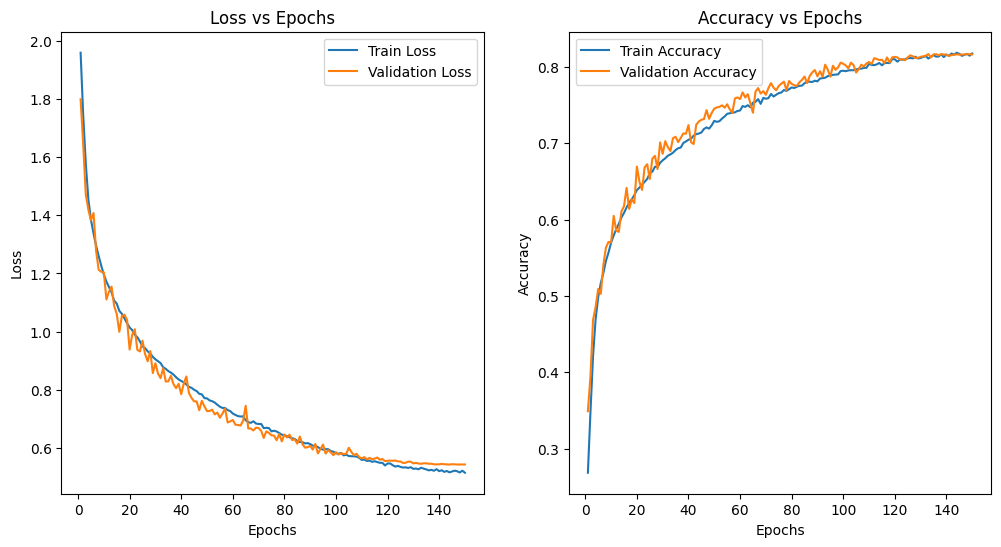

In [10]:
%%time
# 学習・評価の実行
train_eval()


CPU times: user 2h 54min 27s, sys: 24.7 s, total: 2h 54min 52s
Wall time: 2h 54min 33s
